In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [4]:
def generate_clusters(n_clusters=3, points_per_cluster=100, spread=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    centers = np.random.uniform(-1, 1, size=(n_clusters, 2))  # cluster centers
    points = []

    for center in centers:
        cluster_points = np.random.randn(points_per_cluster, 2) * spread + center
        points.append(cluster_points)

    return np.vstack(points), centers


In [20]:
points, centers = generate_clusters(n_clusters=4, points_per_cluster=50, spread=0.05,seed=10)

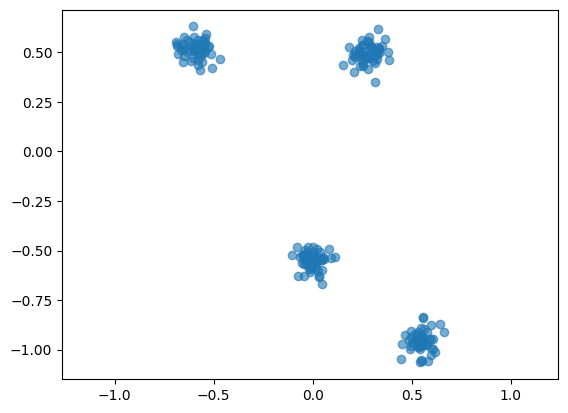

In [22]:
plt.scatter(points[:, 0], points[:, 1], alpha=0.6)
# plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x')  # cluster centers
plt.axis('equal')
plt.show()

In [135]:
class simplefunctions:
    def __init__(self, K):
        self.K=K
        self.num_points= 20 #number of actions
        actionspace =  np.linspace(-1,1,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)
        self.subset = self.algorithm()

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)
        while len(subset)< self.K: # add more items until K distinct actions are found
            f_samples = self.samples(size=self.K-len(subset))
            max_indices = np.argmax(f_samples, axis=1)
            subset = np.append(subset,np.unique(max_indices))
        # print("Unique actions:", subset)
        return subset
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = self.samples(size=num_batches) # np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

In [136]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.1,0.2,0.5,1,1.5,2,2.5,3] #0.1,0.5,1,

for K in [3,5]:
    for length_scale in length_range:
        for ignore in range(10):
            fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary)
            output=fun.test(fun.subset)
            ucb=fun.test(fun.run_ucb())
            ts=fun.test(fun.run_ts())
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [125]:
IfStationary=False
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[1,3,5] #0.1,0.5,1,

for K in [3,5]:
    for ignore in range(5):
        for length_scale in length_range:
            fun=GPfunctions(K,length_scale,IfStationary=IfStationary)
            output=fun.test(fun.subset)
            ucb=fun.test(fun.run_ucb())
            ts=fun.test(fun.run_ts())
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [132]:
report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']

length_scale  K  method 
0.5           3  epsilon    0.911415
                 ts         0.935963
                 ucb        0.993542
              5  epsilon    0.619623
                 ts         0.622498
                 ucb        0.591926
1.0           3  epsilon    0.664749
                 ts         0.674705
                 ucb        0.823774
              5  epsilon    0.443955
                 ts         0.452165
                 ucb        0.404583
1.5           3  epsilon    0.591218
                 ts         0.594321
                 ucb        0.726364
              5  epsilon     0.37363
                 ts         0.301277
                 ucb        0.301419
2.0           3  epsilon    0.487108
                 ts          0.45753
                 ucb        0.667891
              5  epsilon    0.260996
                 ts         0.292494
                 ucb        0.241614
2.5           3  epsilon    0.373896
                 ts         0.463733
             

**Plots**

In [25]:
report=pd.read_csv('report.csv')
length_range=[0.1,0.5,1,1.5,2]

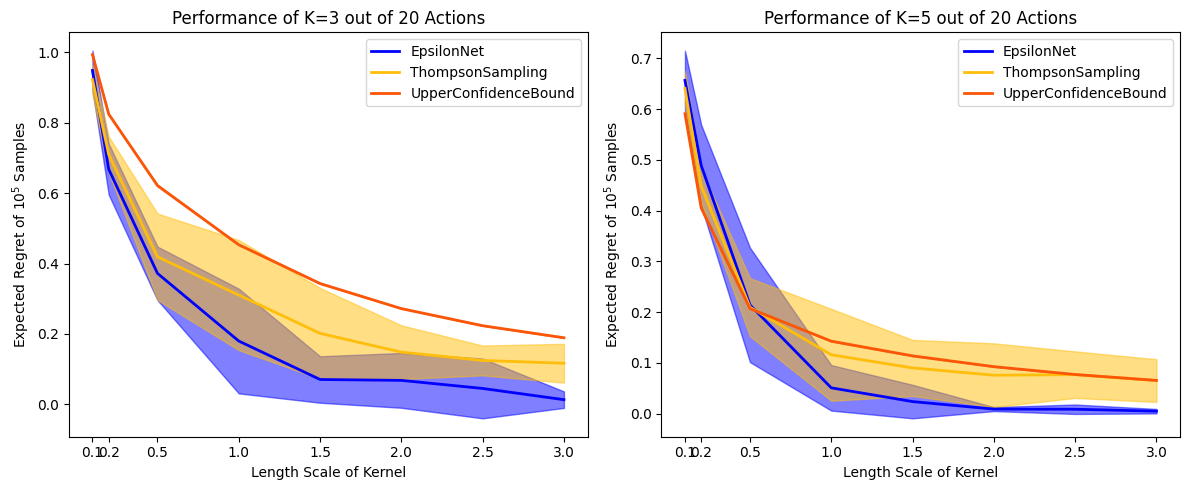

In [138]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [3,5]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
# length_range=[0.5,1,1.5,2,2.5]
for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    # axes[i].set_ylim([0,0.8])
    axes[i].set_title("Performance of K={} out of 20 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

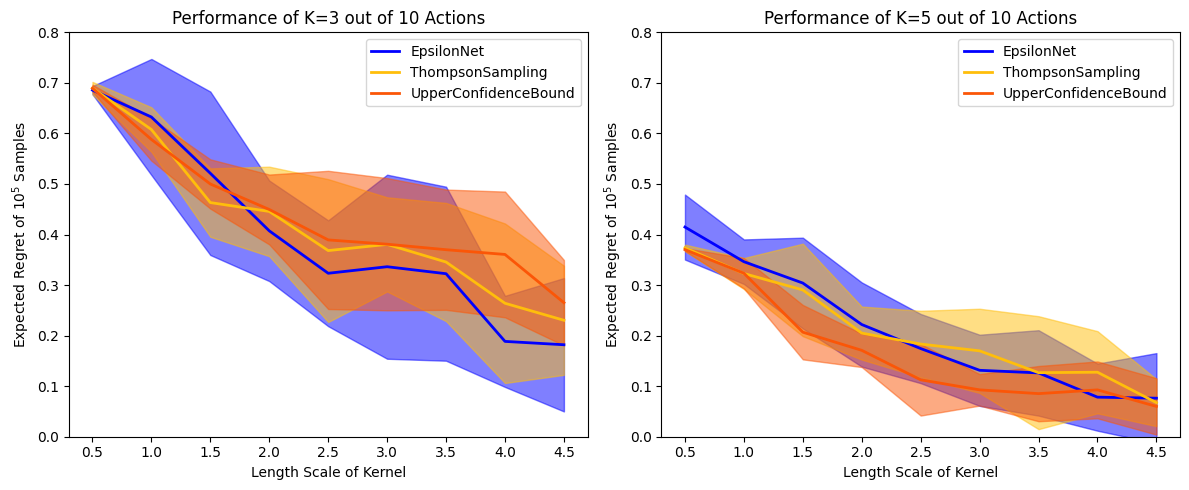

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [3,5]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
# length_range=[0.5,1,1.5,2,2.5]
for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,0.8])
    axes[i].set_title("Performance of K={} out of 10 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

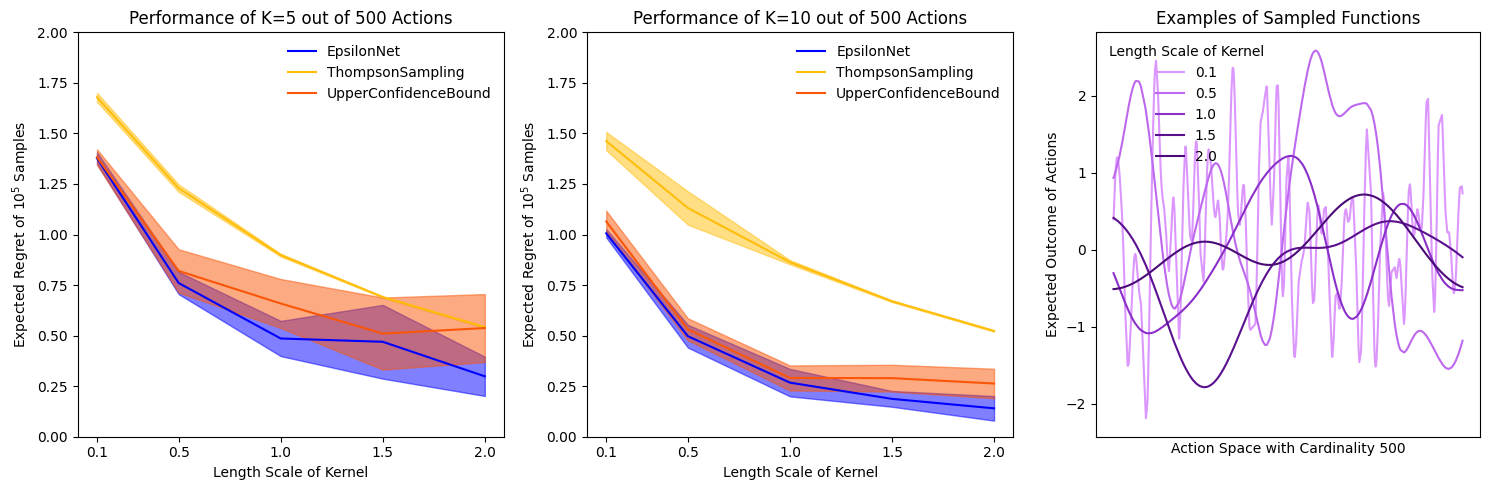

In [68]:
fig, axes = plt.subplots(1,3,figsize=(15, 5), gridspec_kw={'width_ratios': [1,1,0.9]})  # (rows, cols)
# plt.subplots_adjust(wspace=0, hspace=0)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [5,10]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
colormap_sample = dict(zip(length_range, ['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,2])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend(frameon=False)

i=2
for l in length_range:
    fun=GPfunctions(1,l)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap_sample[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',frameon=False)

# Save plot as a PDF without margins
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

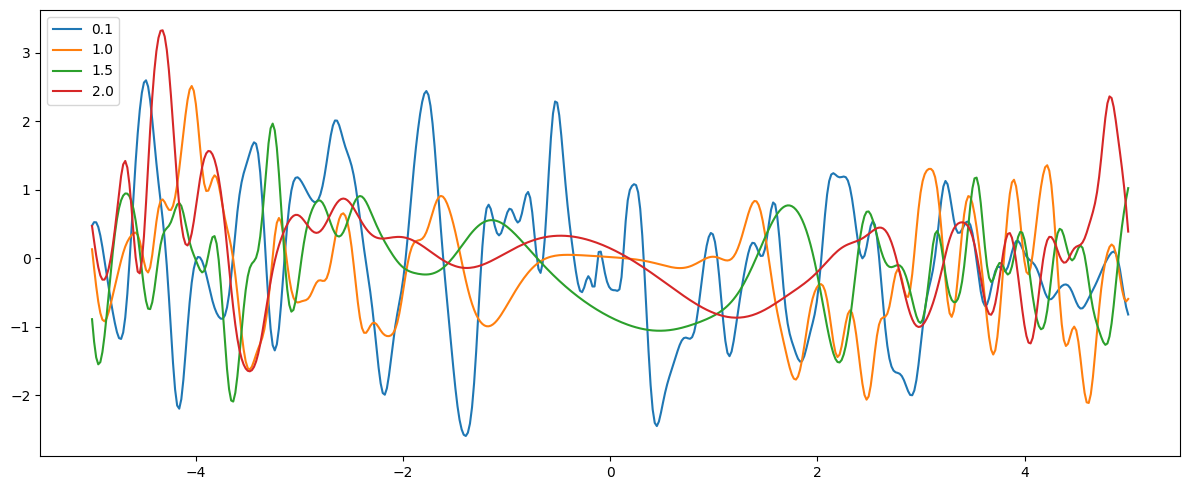

In [93]:
fig, axes = plt.subplots(figsize=(12, 5))  # (rows, cols)

for l in [0.1,1,1.5,2]:
    fun=GPfunctions(1,l,IfStationary=False)
    axes.plot(fun.actionspace,fun.samples(size=1).reshape(-1),label="{:.1f}".format(l))

plt.legend()
# Adjust layout
plt.tight_layout()
plt.show()

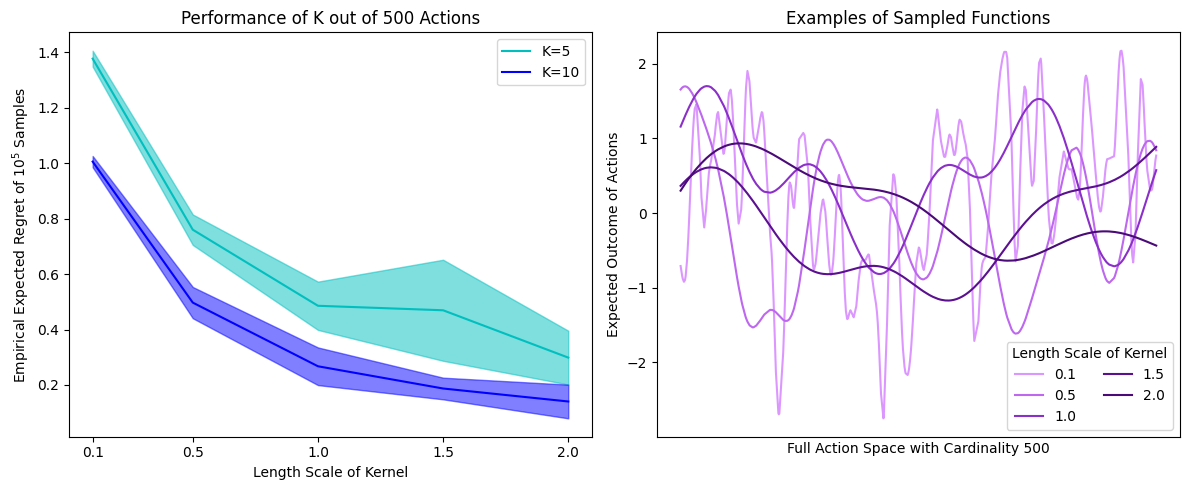

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
colormap = dict(zip([5,10]+length_range, ['c','b']+['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

i=0
for K in [5,10]:
    dfmean=report_ep.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[i][K] for i in length_range])
    dfstd=report_ep.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
    std=np.array([dfstd[i][K] for i in length_range])
    axes[i].plot(length_range, mean, label="K={}".format(K), color=colormap[K])
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[K],alpha=0.5)

# axes[i].set_ylim([0,1.5])
axes[i].set_title("Performance of K out of 500 Actions")
axes[i].set_xlabel("Length Scale of Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Empirical Expected Regret of $10^5$ Samples")
axes[i].legend()

i=1
for l in length_range:
    fun=GPfunctions(1,l,actionspace=actionspace)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Full Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',ncol=2)

# Save plot as a PDF without margins
# plt.savefig("RKHS.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [337]:
def thompson_sampling_action_selection(alpha, beta, K=5):
    """
    Selects a subset of K actions using Thompson Sampling.
    
    alpha, beta: Parameters of the Beta distribution for each action.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    sampled_values = np.random.beta(alpha, beta)  # Sample from Beta distribution
    selected_actions = np.argsort(sampled_values)[-K:]  # Select top K actions
    return selected_actions

# Example usage
num_actions = 10
alpha = np.ones(num_actions)  # Prior successes (initialize as 1)
beta = np.ones(num_actions)   # Prior failures (initialize as 1)
selected_actions = thompson_sampling_action_selection(alpha, beta, K=5)

print("Selected actions using Thompson Sampling:", selected_actions)

Selected actions using Thompson Sampling: [2 5 6 0 7]


In [338]:
def ucb_action_selection(Q, N, t, c=1.0, K=5):
    """
    Selects a subset of K actions using Upper Confidence Bound (UCB).
    
    Q: Estimated rewards for each action.
    N: Number of times each action has been selected.
    t: Current time step.
    c: Exploration-exploitation trade-off parameter.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    ucb_values = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
    selected_actions = np.argsort(ucb_values)[-K:]  # Top K actions with highest UCB
    return selected_actions

# Example usage
num_actions = 10
Q = np.random.rand(num_actions)  # Random estimated rewards
N = np.ones(num_actions)  # Initialize with 1 to avoid division by zero
t = 100  # Current time step
selected_actions = ucb_action_selection(Q, N, t, K=5)

print("Selected actions using UCB:", selected_actions)


Selected actions using UCB: [2 8 9 0 1]


In [194]:


dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
mean=np.array([dfmean[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])
dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
std=np.array([dfstd[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])



In [277]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.968969
             10.0          0.658666
0.2          5.0           0.969845
             10.0          0.612436
0.5          5.0           0.664523
             10.0          0.370710
1.0          5.0           0.515914
             10.0          0.279531
1.5          5.0           0.404753
             10.0          0.112570
2.0          5.0           0.258277
             10.0          0.106087

In [278]:
report.groupby(by=["length_scale",'K']).std()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.008003
             10.0          0.031927
0.2          5.0           0.055027
             10.0          0.108203
0.5          5.0           0.080587
             10.0          0.053958
1.0          5.0           0.117663
             10.0          0.056348
1.5          5.0           0.069309
             10.0          0.059978
2.0          5.0           0.086438
             10.0          0.048114